<a href="https://colab.research.google.com/github/the-faisalahmed/Optimization/blob/main/Slant_Puzzle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ortools
from IPython.display import Image
from ortools.sat.python import cp_model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import random

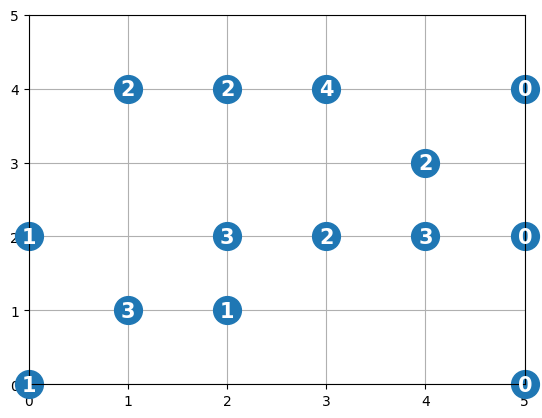

In [2]:
x = [0,0,1,1,2,2,2,3,3,4,4,5,5,5]
y = [0,2,1,4,1,2,4,2,4,2,3,0,2,4]
val = [1,1,3,2,1,3,2,2,4,3,2,0,0,0]

plt.xlim(0,5)
plt.ylim(0,5)

plt.scatter(x,y,marker = 'o', s = 400, clip_on=False, alpha = 1, zorder = 2)
for i in range(len(x)):
  plt.text(x[i]-.07,y[i]-.09,val[i], color = '#FFFFFF', fontsize = 15, weight = 'semibold', zorder = 3)

plt.grid(True, which = 'major', zorder = 1)
#plt.savefig('pic1.png')
plt.show()

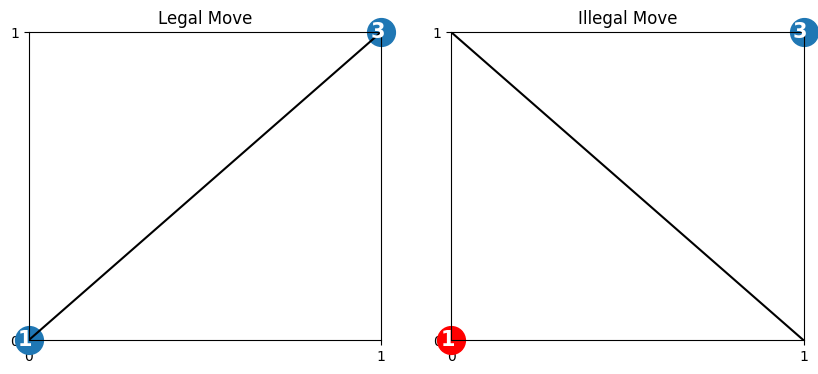

In [3]:
test = [1,3]

fig, axs = plt.subplots(1,2, figsize=(10, 4));

for i in [0,1]:
  axs[i].set_xlim([0, 1])
  axs[i].set_ylim([0, 1])
  axs[i].set_xticks([0,1])
  axs[i].set_yticks([0,1])

for i in [0,1]:
  axs[0].scatter(i,i,marker = 'o', color = '#1f77b4', s = 400, clip_on=False, alpha = 1, zorder = 2);
  axs[0].text(i-.03,i -.02,test[i], color = '#FFFFFF', fontsize = 15, weight = 'semibold', zorder = 3);
axs[0].plot((0,1),(0,1), color = 'k');
axs[0].set_title('Legal Move');


for i in [0,1]:
  if (i,i) == (0,0):
    axs[1].scatter(i,i,marker = 'o', color = 'red', s = 400, clip_on=False, alpha = 1, zorder = 2);
    axs[1].text(i-.03,i -.02,test[i], color = '#FFFFFF', fontsize = 15, weight = 'semibold', zorder = 3);
  else:
    axs[1].scatter(i,i,marker = 'o', color = '#1f77b4', s = 400, clip_on=False, alpha = 1, zorder = 2);
    axs[1].text(i-.03,i -.02,test[i], color = '#FFFFFF', fontsize = 15, weight = 'semibold', zorder = 3);
axs[1].plot((1,0),(0,1), color = 'k');
axs[1].set_title('Illegal Move');

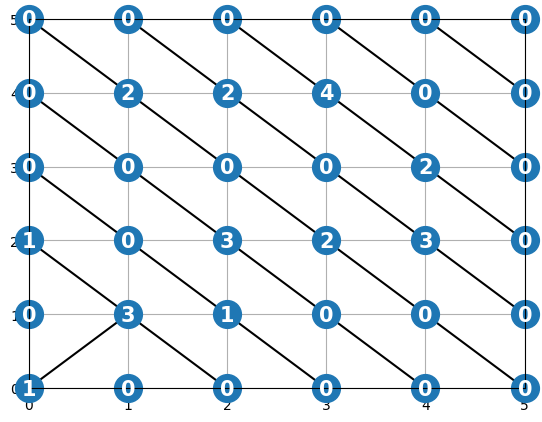

Status = OPTIMAL


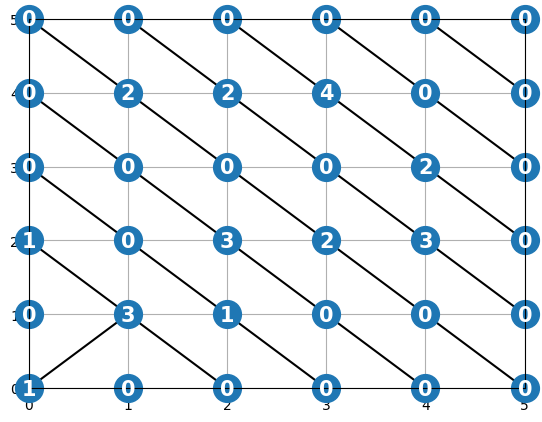

Status = OPTIMAL


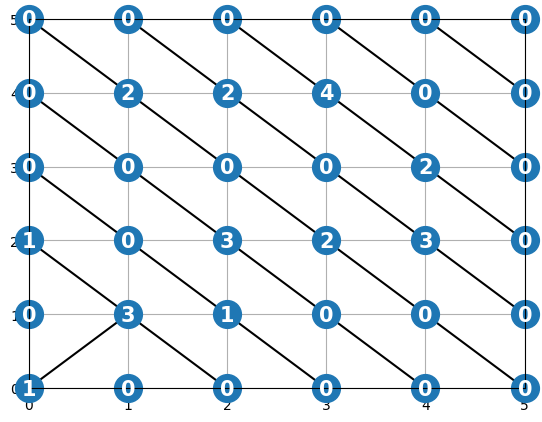

Status = OPTIMAL


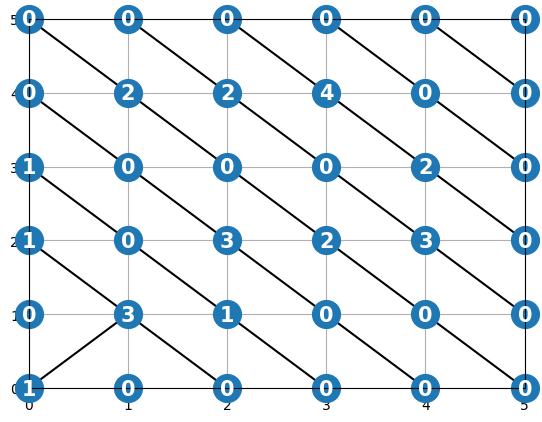

Status = OPTIMAL


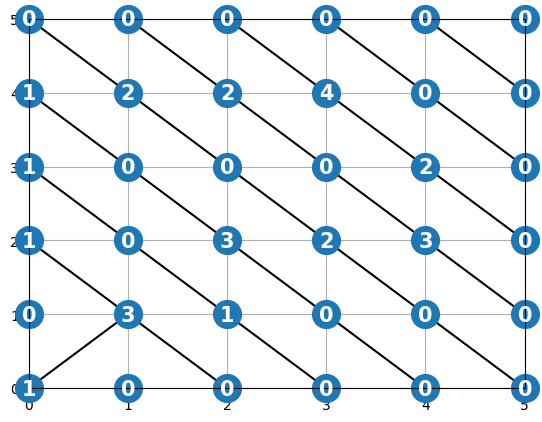

Status = OPTIMAL


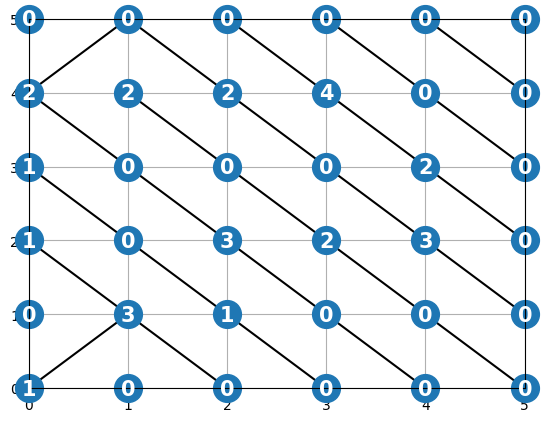

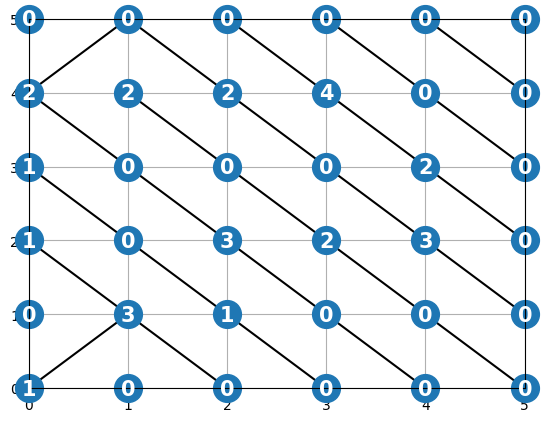

Status = OPTIMAL


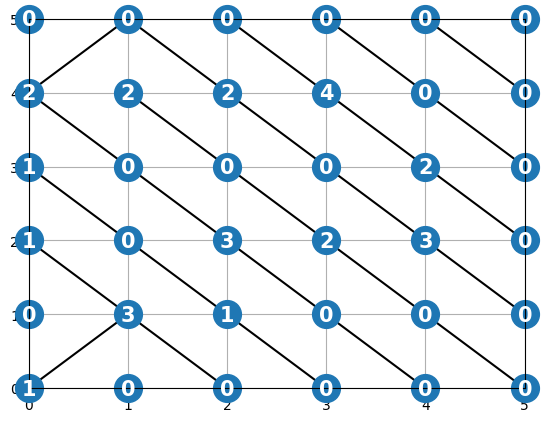

Status = OPTIMAL


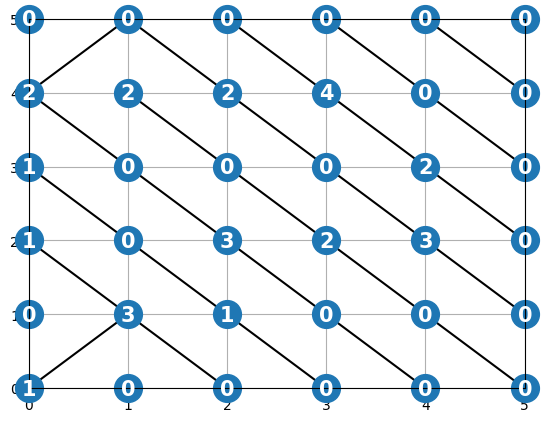

Status = OPTIMAL


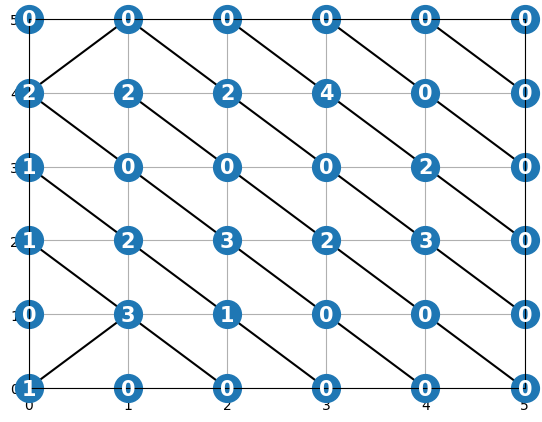

Status = OPTIMAL


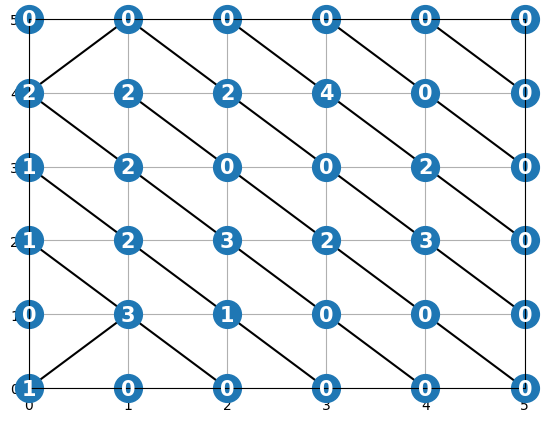

Status = OPTIMAL


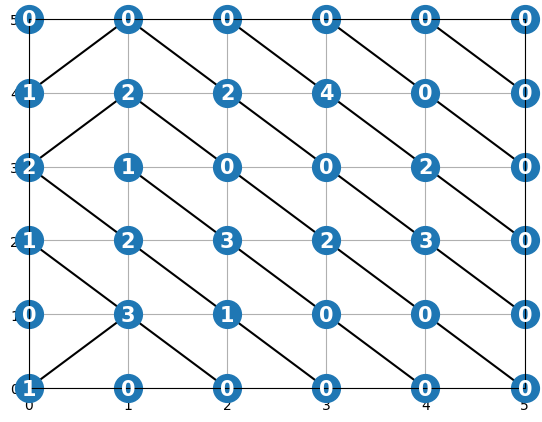

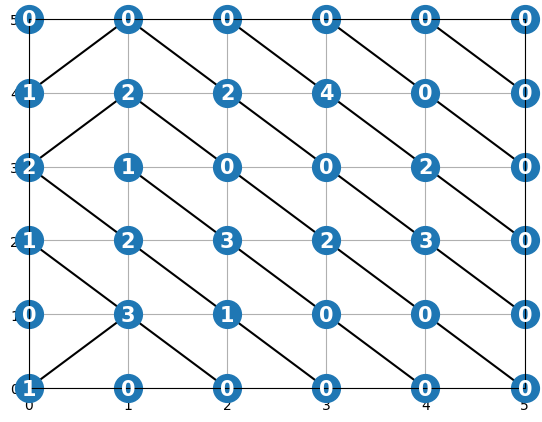

Status = OPTIMAL


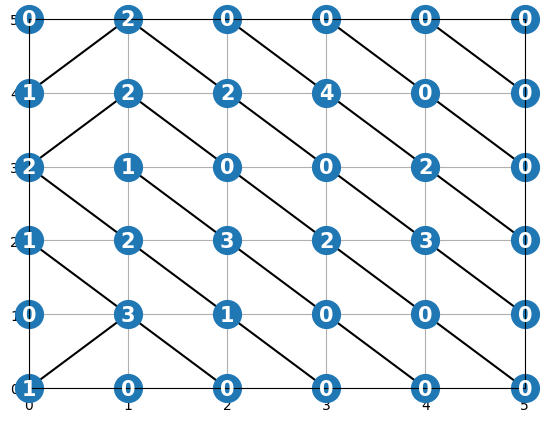

Status = OPTIMAL


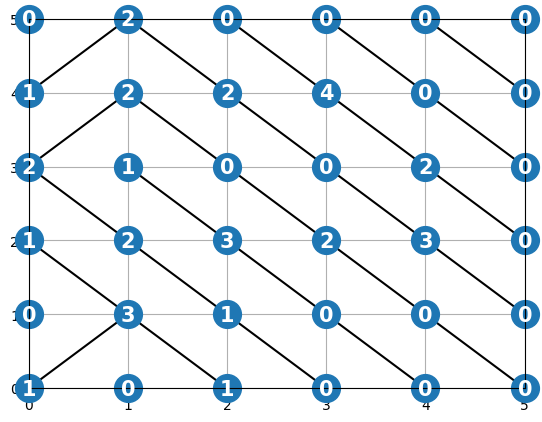

Status = OPTIMAL


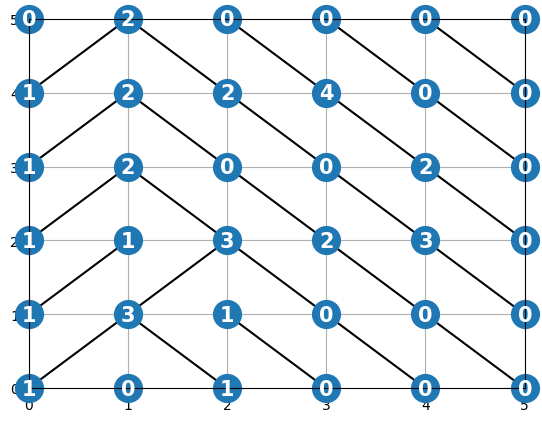

Status = OPTIMAL


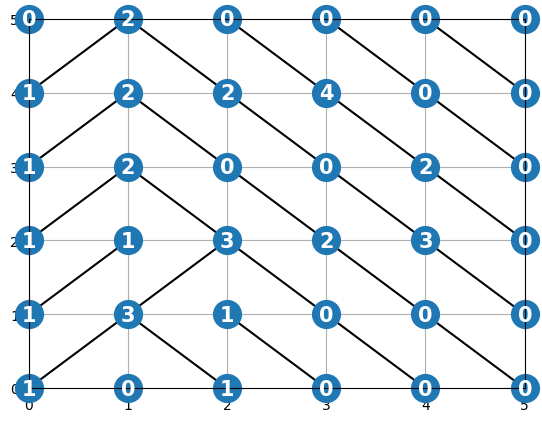

Status = OPTIMAL


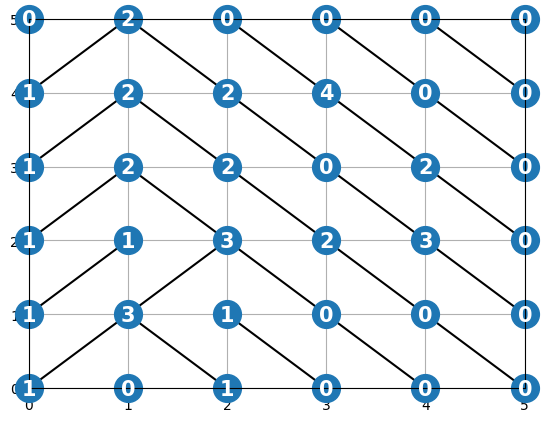

Status = OPTIMAL


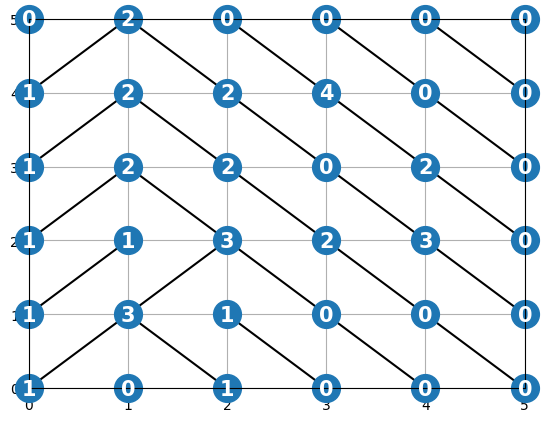

Status = OPTIMAL


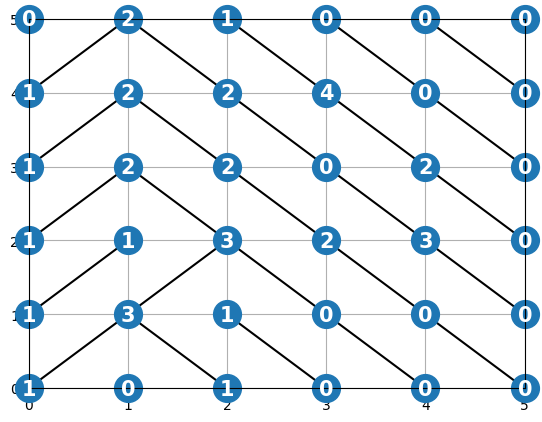

Status = OPTIMAL


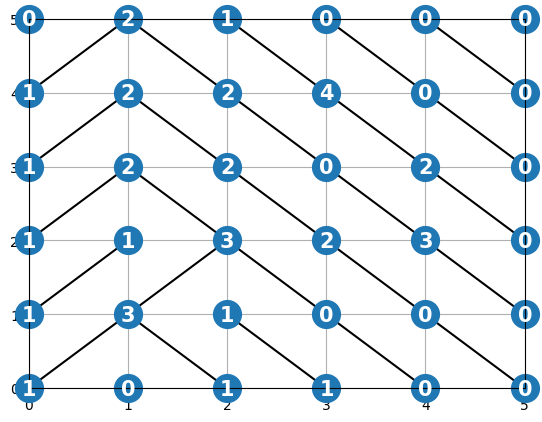

Status = OPTIMAL


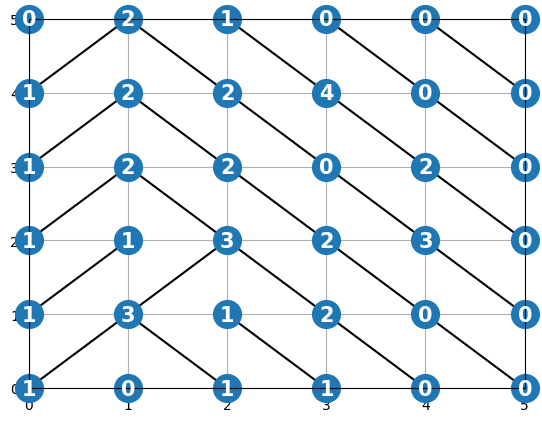

Status = OPTIMAL


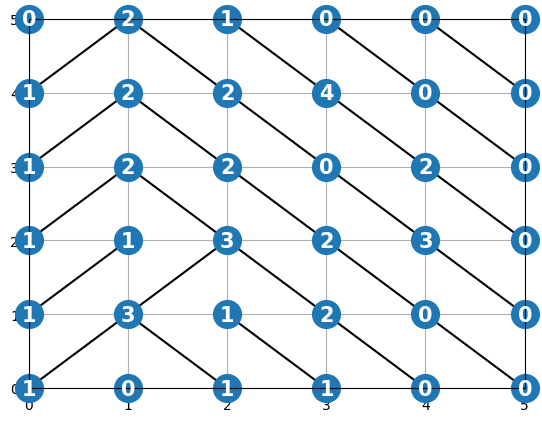

Status = OPTIMAL


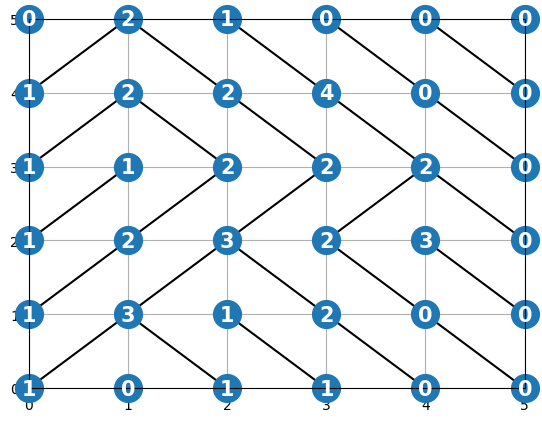

Status = OPTIMAL


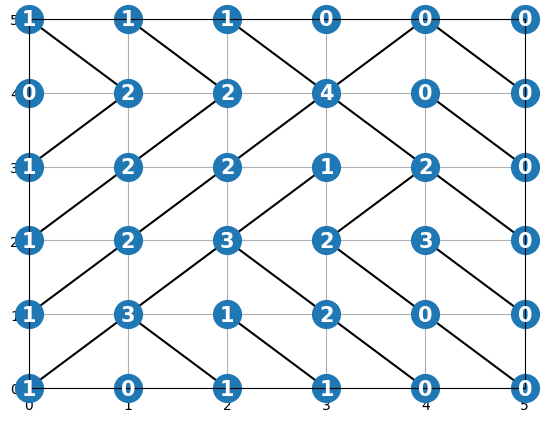

Status = OPTIMAL


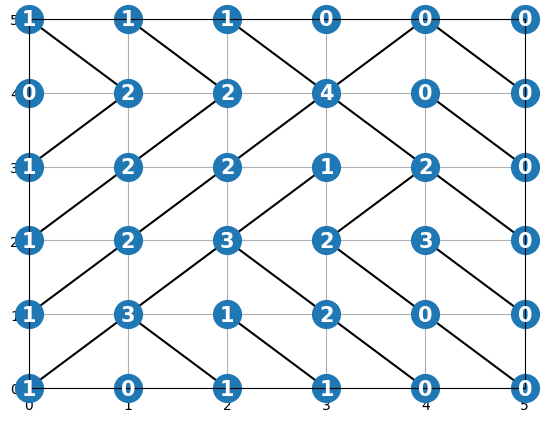

Status = OPTIMAL


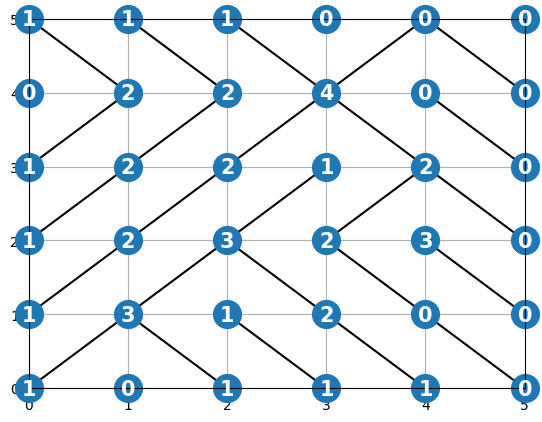

Status = OPTIMAL


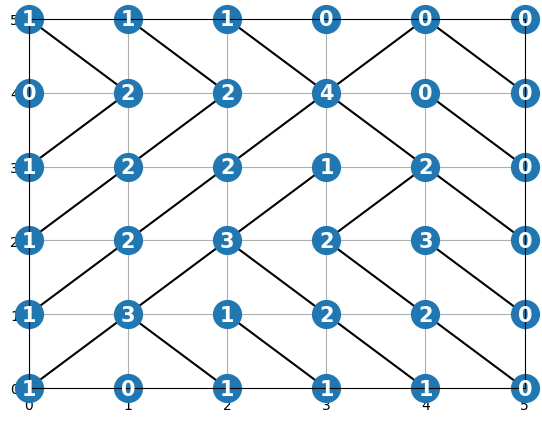

Status = OPTIMAL


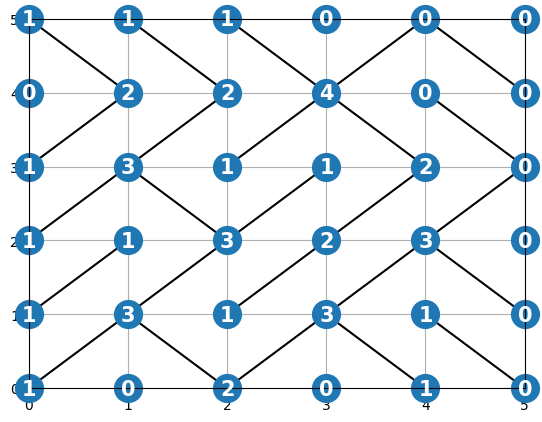

Status = OPTIMAL


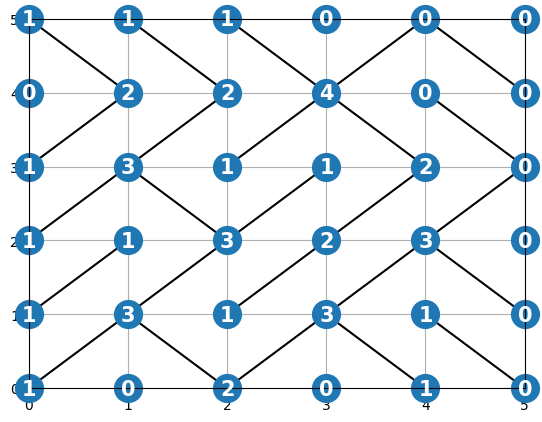

Status = OPTIMAL


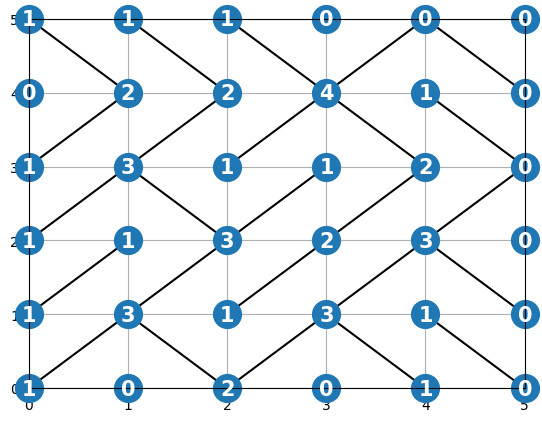

Status = OPTIMAL


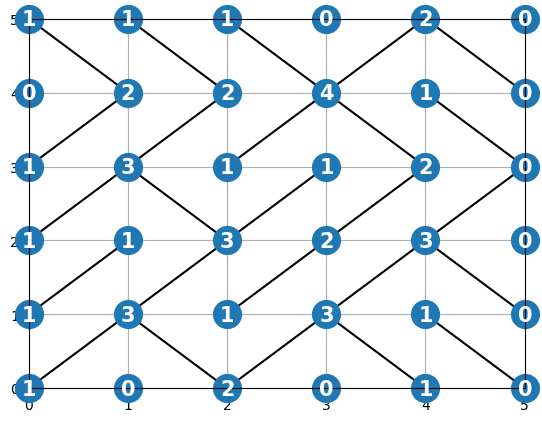

Status = OPTIMAL


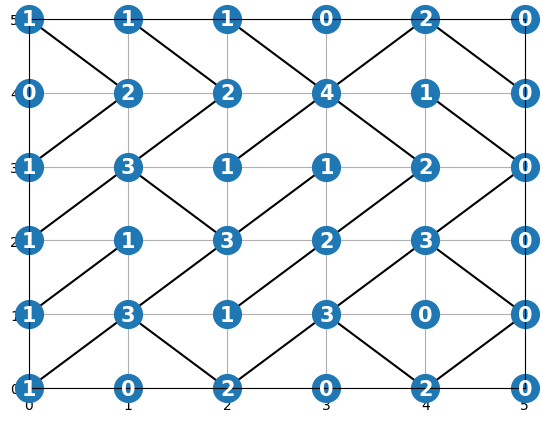

Status = OPTIMAL


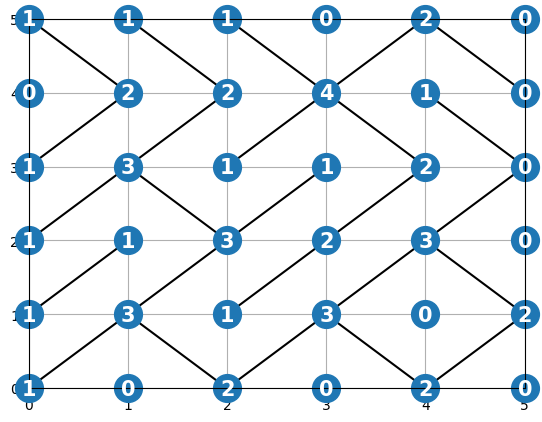

Status = OPTIMAL


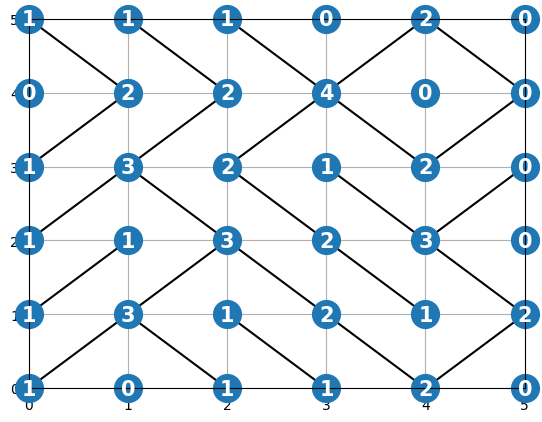

Status = OPTIMAL


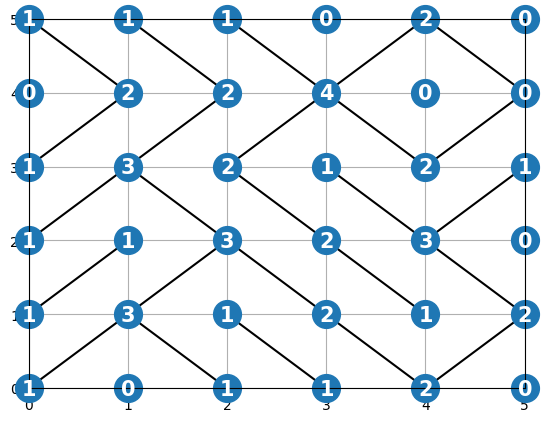

Status = OPTIMAL


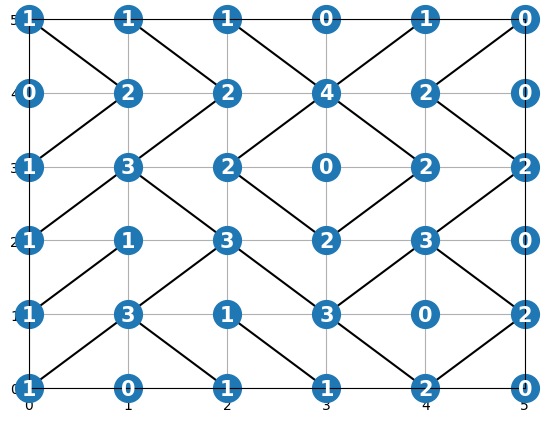

Status = OPTIMAL


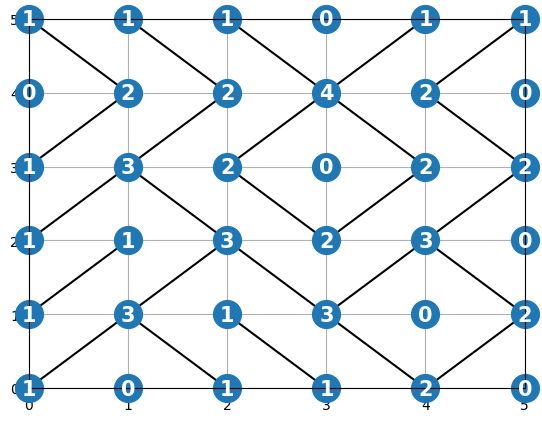

Status = OPTIMAL


In [4]:
class VarArraySolutionPrinter(cp_model.CpSolverSolutionCallback):
    def __init__(self, variables):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.__variables = variables
        self.__solution_count = 0

    def on_solution_callback(self):
        #self.solution_list.append([self.Value(v) for v in self.__variables])
        self.__solution_count += 1

        # Total Values
        totals = {}
        for v in self.__variables[0]:
          totals[v] = self.Value(self.__variables[0][v])

        # Slant Solution
        sol = {}
        for v in self.__variables[1]:
          sol[v] = self.Value(self.__variables[1][v])

        plt.xlim(0,5)
        plt.ylim(0,5)

        for i,j in totals.keys():
          plt.scatter(i,j,marker = 'o', color = '#1f77b4', s = 400,
                      clip_on=False, alpha = 1, zorder = 2)
          plt.text(i-.07,j-.09,int(totals[i,j]), color = '#FFFFFF',
                   fontsize = 15, weight = 'semibold', zorder = 3)

        for i,j in sol.keys():
          if sol[i,j] == 1:
            plt.plot((i,i+1),(j,j+1), color = 'k', zorder = 0)
          else:
            plt.plot((i+1,i),(j,j+1),color = 'k', zorder = 0)

        plt.grid(True, which = 'major', zorder = 1)
        #plt.savefig('finished.png')
        plt.show()

    def solution_count(self):
        return self.__solution_count

def ModelFormulation(x,y,val):
  model = cp_model.CpModel()

  I = range(0,6)
  J = range(0,5)

  var = {}
  square = {}

  for i in I:
    for j in I:
      var[i,j] = model.NewIntVar(0,4,f"var_{i}_{j}")

  for i in J:
    for j in J:
      square[i,j] = model.NewBoolVar(f"square_{i}_{j}")

  for i in range(len(val)):
    model.Add(var[x[i],y[i]] == val[i])

  for (i,j) in var.keys():
    if (i,j) == (0,0):
      model.Add(var[i,j] == square[i,j])
    elif (i,j) == (5,5):
      model.Add(var[i,j] == square[i-1,j-1])
    elif (i,j) == (0,5):
      model.Add(var[i,j] == 1 - square[i,j-1])
    elif (i,j) == (5,0):
      model.Add(var[i,j] == 1 - square[i-1,j])
    elif 0 < i < 5 and j == 0:
      model.Add(var[i,j] == (1 - square[i-1,j]) + square[i,j])
    elif 0 < i < 5 and j == 5 :
      model.Add(var[i,j] == square[i-1,j-1] + (1 - square[i,j-1]))
    elif 0 < j < 5 and i == 0 :
      model.Add(var[i,j] == (1 - square[i,j-1]) + square[i,j])
    elif 0 < j < 5 and i == 5 :
      model.Add(var[i,j] == square[i-1,j-1] + (1 - square[i-1,j]))
    else:
      model.Add(var[i,j] == square[i-1,j-1] + square[i,j] + 2 - square[i,j-1] - square[i-1,j])

    # Create a solver and solve.
    solver = cp_model.CpSolver()
    solution_printer = VarArraySolutionPrinter([var,square])

    # Enumerate all solutions.
    solver.parameters.enumerate_all_solutions = False

    status = solver.Solve(model, solution_printer)

    print(f"Status = {solver.StatusName(status)}")

ModelFormulation(x,y,val)